To run all 4 Notebooks we recommend creating a new environment and install the following packages:

```
pip install jupyterlab pandas pandas matplotlib obspy h5py networkx --no-cache-dir
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --no-cache-dir
pip install torcheval --no-cache-dir
```

We used python 3.8.10

In [4]:
import numpy as np
import pandas as pd

from obspy.clients.fdsn import Client
from obspy.core.event import read_events

import os
import pickle

import time
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

masterdir = '/home/seismoai/data/forecasting/'

In [2]:
def getEarthquakeCatalog(start, end, location, count, delta, minmagnitude, client_i):

    # see https://docs.obspy.org/packages/obspy.clients.fdsn.html for other services
    client = Client(client_i)
    
    # download earthquake catalog
    catalog = client.get_events(
        minlatitude  = location[0] - delta, 
        maxlatitude  = location[0] + delta,
        minlongitude = location[1] - delta, 
        maxlongitude = location[1] + delta, 
        starttime    = start,
        endtime      = end,
        minmagnitude = minmagnitude
    )
    
    print('finished {:01} of year {}     {} Events in last request'.format(count, start[:4], len(catalog)), end='\r')
    return catalog

In [3]:
drange = [
    ['1900-01-01'] + 
    [str(i.date()) for i in pd.date_range(start="1964-01-01",end="1990-01-01", freq='ys')][:-1] + 
    [str(i.date()) for i in pd.date_range(start="1990-01-01",end="1999-01-01", freq='MS')][::6] + 
    [str(i.date()) for i in pd.date_range(start="1999-01-01",end=pd.to_datetime("today"), freq='SMS')[1::]]
         ][0]


In [12]:
def downloadData(drange, mpath, start_i=0):
    t0 = time.time()
    tfile = 'magnitude_types.dat'
    open(mpath+tfile, 'w').close()
    for i in range(len(drange)-1):
        filename = mpath+'Japan_{:03d}_{}.dict'.format(i, drange[i])
        if os.path.isfile(filename):
            continue
        if i < start_i:
            continue
            
        print('Requesting data {} to {} ({:3d} of {:3d})'.format(drange[i], drange[i+1], i+1, len(drange)-1), end='\r')
        catalog_local = getEarthquakeCatalog(drange[i], drange[i+1], [35, 135], 100, 15, 0.0, 'ISC')
        with open(filename, 'wb') as f:
            pickle.dump(catalog_local, f)
        print('Data received   {} to {} ({:3d} of {:3d}) | {:5d} Events | Getting Mtypes now!'.format(drange[i], drange[i+1], i+1, len(drange)-1, len(catalog_local)))
        
        mt = []
        for e in catalog_local:
            for m in e.magnitudes:
                if m.magnitude_type not in mt:
                    mt.append(m.magnitude_type)
        with open(mpath+'magnitude_types.dat', 'a') as mt_file:
            mt_file.write('File {:3d} ({: >5d} EQs): '.format(i, len(catalog_local))+str(mt)[1:-1]+'\n')
    t1 = time.time()
    print('Finished Downloading Data. Time: {:6.1f}s \n'.format(t1-t0))
    
def processToPandas(mpath):
    import re
    t0 = time.time()
    # get list via os
    onlyfiles = sorted([f for f in os.listdir(mpath) if os.path.isfile(os.path.join(mpath, f))])
    # get magnitude types from file
    with open(mpath+onlyfiles[-1], 'r') as mt_file:
        mt_raw = mt_file.readlines()
        mt_raw = [l.split(':')[1].split(',') for l in mt_raw]
        mt_mult = []
        for m1 in mt_raw:
            for m2 in m1:
                results = re.search('\'(.*)\'', m2)
                mt_mult.append(results.group(1))
        mt = np.unique(mt_mult)
   
        df_total = pd.DataFrame(columns=['time', 'latitude', 'longitude', 'depth'])

        for j in mt:
            df_total[j] = ''

    for i, fn in enumerate(onlyfiles[:-1]):
        print('Reading datafile  | ({:3d} of {:3d})'.format(i+1, len(onlyfiles)-1), end='\r')
        with open(mpath+fn, 'rb') as f:
            catalog_local = pickle.load(f)
            print('Filling dataframe | ({:3d} of {:3d} | {:>5d} EQs)'.format(i+1, len(onlyfiles)-1, catalog_local.count()))
            earthquakes = [
                (j.origins[0].time.datetime,               # source time
                 j.origins[0].latitude,                    # epicenter latitude
                 j.origins[0].longitude,                   # epicenter longitude
                 j.origins[0].depth)                       # depth of earthquake (in meters)
                for j in catalog_local] 

            df = pd.DataFrame(earthquakes, columns=['time', 'latitude', 'longitude', 'depth'])

            for j in mt:
                df[j] = ''

            for j, data in enumerate(catalog_local):
                for k in data.magnitudes:
                    df.at[j,k.magnitude_type] = k.mag

            # sort by time 
            df.sort_values('time', inplace=True)
            df.reset_index(inplace=True, drop=True)

            #df_total.append(df, ignore_index=True)
            df_total = pd.concat((df_total, df), ignore_index=True)

    df_total.to_pickle(masterdir+'Japan_ISC.df')
    t1 = time.time()
    print('Finished Creating Dataframe. Time:  {:6.1f}s \n'.format(t1-t0))

# 1. Download Data

1) Set path to which the data will be downloaded (path must exist and be empty, don't add other files to the directory)
2) Download the data (this takes several hours)

In [13]:
mpath = masterdir + 'downloads/'

In [5]:
downloadData(drange, mpath) 

Finished Downloading Data. Time:    0.1s 



# 2. Primary Processing

Create a Pandas Dataset with the relevant information, not containing any magnitude conversion yet

In [14]:
processToPandas(mpath)

Filling dataframe | (  1 of 661 |  1268 EQs)
Filling dataframe | (  2 of 661 |   476 EQs)
Filling dataframe | (  3 of 661 |   563 EQs)
Filling dataframe | (  4 of 661 |   560 EQs)
Filling dataframe | (  5 of 661 |   557 EQs)
Filling dataframe | (  6 of 661 |  1091 EQs)
Filling dataframe | (  7 of 661 |   891 EQs)
Filling dataframe | (  8 of 661 |   528 EQs)
Filling dataframe | (  9 of 661 |   512 EQs)
Filling dataframe | ( 10 of 661 |   713 EQs)
Filling dataframe | ( 11 of 661 |   874 EQs)
Filling dataframe | ( 12 of 661 |   688 EQs)
Filling dataframe | ( 13 of 661 |   902 EQs)
Filling dataframe | ( 14 of 661 |   795 EQs)
Filling dataframe | ( 15 of 661 |  1046 EQs)
Filling dataframe | ( 16 of 661 |  2247 EQs)
Filling dataframe | ( 17 of 661 |  1844 EQs)
Filling dataframe | ( 18 of 661 |  2450 EQs)
Filling dataframe | ( 19 of 661 |  1702 EQs)
Filling dataframe | ( 20 of 661 |  2966 EQs)
Filling dataframe | ( 21 of 661 |  3313 EQs)
Filling dataframe | ( 22 of 661 |  4550 EQs)
Filling da

# 3. Clean Catalog

For the next step, we only want the earthquakes where a magnitude is reported, and only if there are certain magnitude types.
These Magnitude Types are:
- Mw
- M (M_JMA)
- mb 
- Ms  

Take all events where one of these magnitudes is reported and save them to an npz file.

In [15]:
def Ms2Mw(Ms):
    return np.where(
        Ms == Ms, 
        np.where(Ms < 6.15, 0.65 * Ms + 2.2, Ms - 0.02), # 3.0 - 6.1 | 6.2 - 8.0
        np.nan)
    
def mb2Mw(mb):
    return 0.85*mb + 1.02
    
def M2Mw(M):
    return np.where(
        M == M, 
        np.where(M < 5.55, 0.58*M+2.25, 0.97*M+0.04), # 3-5.5 | 5.6 - 8.2
        np.nan) 

def doMwConversion(df, conversions):
    Mw = conversions[0][1](np.array(df[df.columns[conversions[0][0]]]))
    if len(conversions) > 2:
        for i, f in conversions[1:]:
            Mw = fillWith(Mw, f(np.array(df[df.columns[i]])))
    elif len(conversions) == 2:
        i, f = converions[1]
        Mw = fillWith(Mw, f(np.array(df[df.columns[i]])))
    return Mw 

def fillWith(Mw, Mn):
    return np.where(np.logical_and(Mw != Mw,  Mn==Mn), Mn, Mw)

In [16]:
catalog = pd.read_pickle('Japan_ISC.df')

print('Magnitude Index   Counts')
for i in range(4, len(catalog.columns)):
    print('{:>9}    {:>2d} {:8d}'.format(catalog.columns[i], i, np.sum(~np.isnan(np.array(catalog[catalog.columns[i]])))))

Magnitude Index   Counts
       Mj     4       61
       Ms     5       91
       Mw     6       46
       UK     7       17
       MS     8    23843
       mb     9   117163
        M    10  2112472
      MLH    11      191
       ML    12   760920
       mL    13      354
      MPV    14        4
      MSH    15       14
       Mb    16       68
       md    17      453
     MPLP    18        1
     MSHA    19       36
     MPVA    20      575
      Msz    21        9
     MLHK    22      127
     MPSP    23        4
      JMA    24       40
       ms    25       46
      mb1    26     5124
    mb1mx    27     5122
      Ms1    28      967
    ms1mx    29      967
      mbv    30        5
      msh    31       18
     Mbva    32        1
      Msh    33        1
       MU    34       27
      Mbv    35       11
    mbtmp    36    11851
       MG    37        5
       mB    38      152
      Ms7    39        6
       MW    40      212
       MV    41  1299054
       MD    42       95


In [17]:
conversions = [
    [ 8, Ms2Mw], # MS
    [ 9, mb2Mw], # mb
    [12,  M2Mw], # ML
    [41,  M2Mw], # MV
    [10,  M2Mw], # M
]

Create Numpy File for futher processing in the next notebook.  
The numpy file will contain all earthquakes that have a magnitude after the conversion.  
The Columns are:
 - Date + Time (np.datetime64)
 - Latitude
 - Longitude
 - Magnitude
 - Depth


In [18]:
t0 = time.time()
mags = doMwConversion(catalog, conversions)
print('By Conversion {:7.4f}% of events are lost.'.format(100*np.sum(np.isnan(mags)/len(mags))))

sel = mags == mags

with open(masterdir + 'Japan_ISC.npz', 'wb') as fo:
    dat = np.array([np.datetime64(t) for t in np.array(catalog['time'])])[sel]
    lat = np.array(catalog['latitude'])[sel]
    lon = np.array(catalog['longitude'])[sel]
    mag = mags[sel]
    dep = np.array(catalog['depth'])[sel]
    np.savez(fo, dat=dat, lat=lat, lon=lon, mag=mag, dep=dep)
t1 = time.time()
print('Saved File with {} events after {:5.2f}s.'.format(np.sum(sel), t1-t0))

By Conversion  0.0477% of events are lost.
Saved File with 4284094 events after 12.34s.


# 4. Check Quality in the Catalog

In [19]:
def analyzeHistograms(catalog, conversions):
    bins = np.arange(0, 8, 0.1)
    
    fig, ax = plt.subplots(2, len(conversions), figsize=(1.5*len(conversions), 3), dpi=300, sharex=True, sharey=True)
    ax[0,0].set_xlim(bins[0], bins[-1])
    
    for i, (mx, func) in enumerate(conversions):
        mags = np.array(catalog[catalog.columns[mx]])
        hist, _ = np.histogram(mags, bins=bins)
        ax[0, i].bar(bins[:-1] + 0.05, hist/hist.max())
        ax[0, i].set_title(catalog.columns[mx])
        ax[0, i].text(0.5, 0.9, (mags>=5).sum(), fontsize=8)
        
        mags = func(mags)
        hist, _ = np.histogram(mags, bins=bins)
        ax[1, i].bar(bins[:-1] + 0.05, hist/hist.max())
        ax[1, i].text(0.05, 0.9, (mags>=5).sum(), fontsize=8)
        
        ax[0, i].axvline(5, color='r', lw=0.5)
        ax[1, i].axvline(5, color='r', lw=0.5)
        

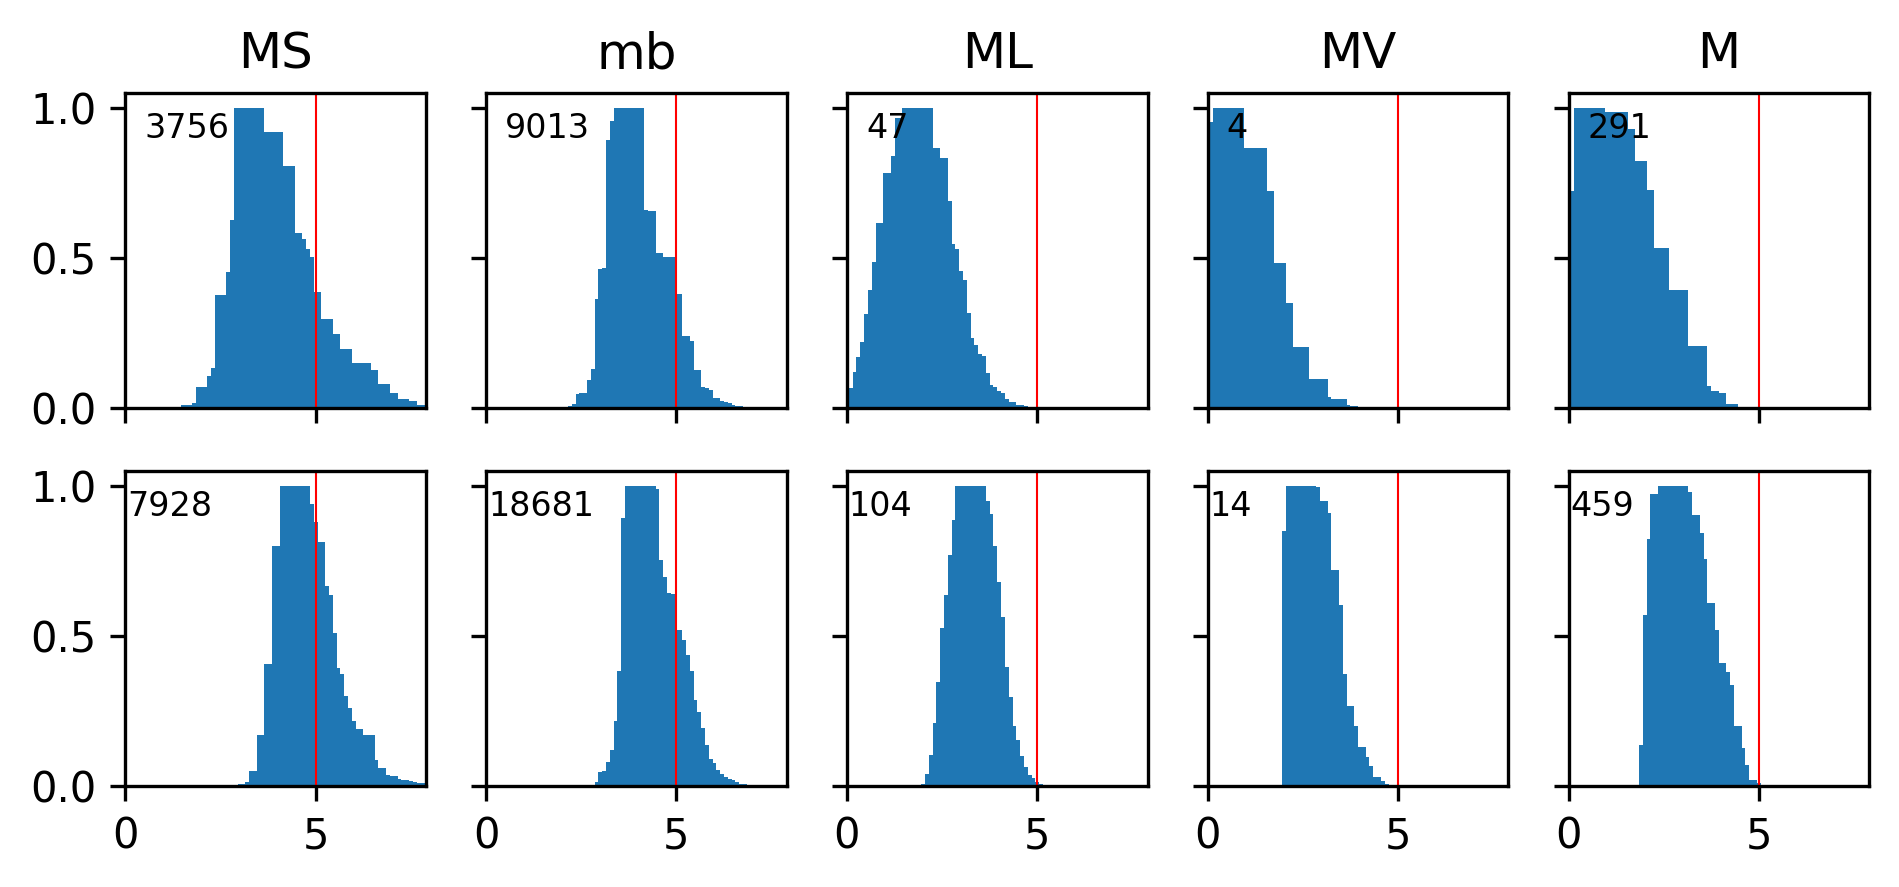

In [20]:
analyzeHistograms(catalog, conversions)


Many smaller events are not added immediately to the catalog.  
Check the number of earthquakes per 2 week file to see how far they have been added

In [21]:
def check_EQ_per_file(mpath):
    onlyfiles = sorted([f for f in os.listdir(mpath) if os.path.isfile(os.path.join(mpath, f))])[:-1] 
    drange_read = []
    ncount_dr = []
    for i, fn in enumerate(onlyfiles[:-1]):
        print('Reading datafile  | ({:3d} of {:3d})'.format(i+1, len(onlyfiles)), end='\r')
        with open(mpath+fn, 'rb') as f:
            catalog_local = pickle.load(f)
            drange_read.append(fn.split('.')[0][-10:])
            ncount_dr.append(catalog_local.count())
                
    return drange_read, ncount_dr
        
def plot_EQ_per_file(names, numbers, startdate=(1999, 1, 1), enddate=(2024, 1, 1)):
    startdate = datetime.datetime(*startdate)
    enddate = datetime.datetime(*enddate)
    fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=300)
    times = [datetime.datetime.strptime(label, '%Y-%m-%d') for label in names]
    ax.plot(times, numbers)
    xlims = [startdate, enddate]
    ax.set_xlim(xlims)
    ax.set_xlabel('Date')
    ax.set_ylim(0)
    ax.set_ylabel('Earthquakes within 2 weeks')

In [22]:
datestrings, counts = check_EQ_per_file(mpath)

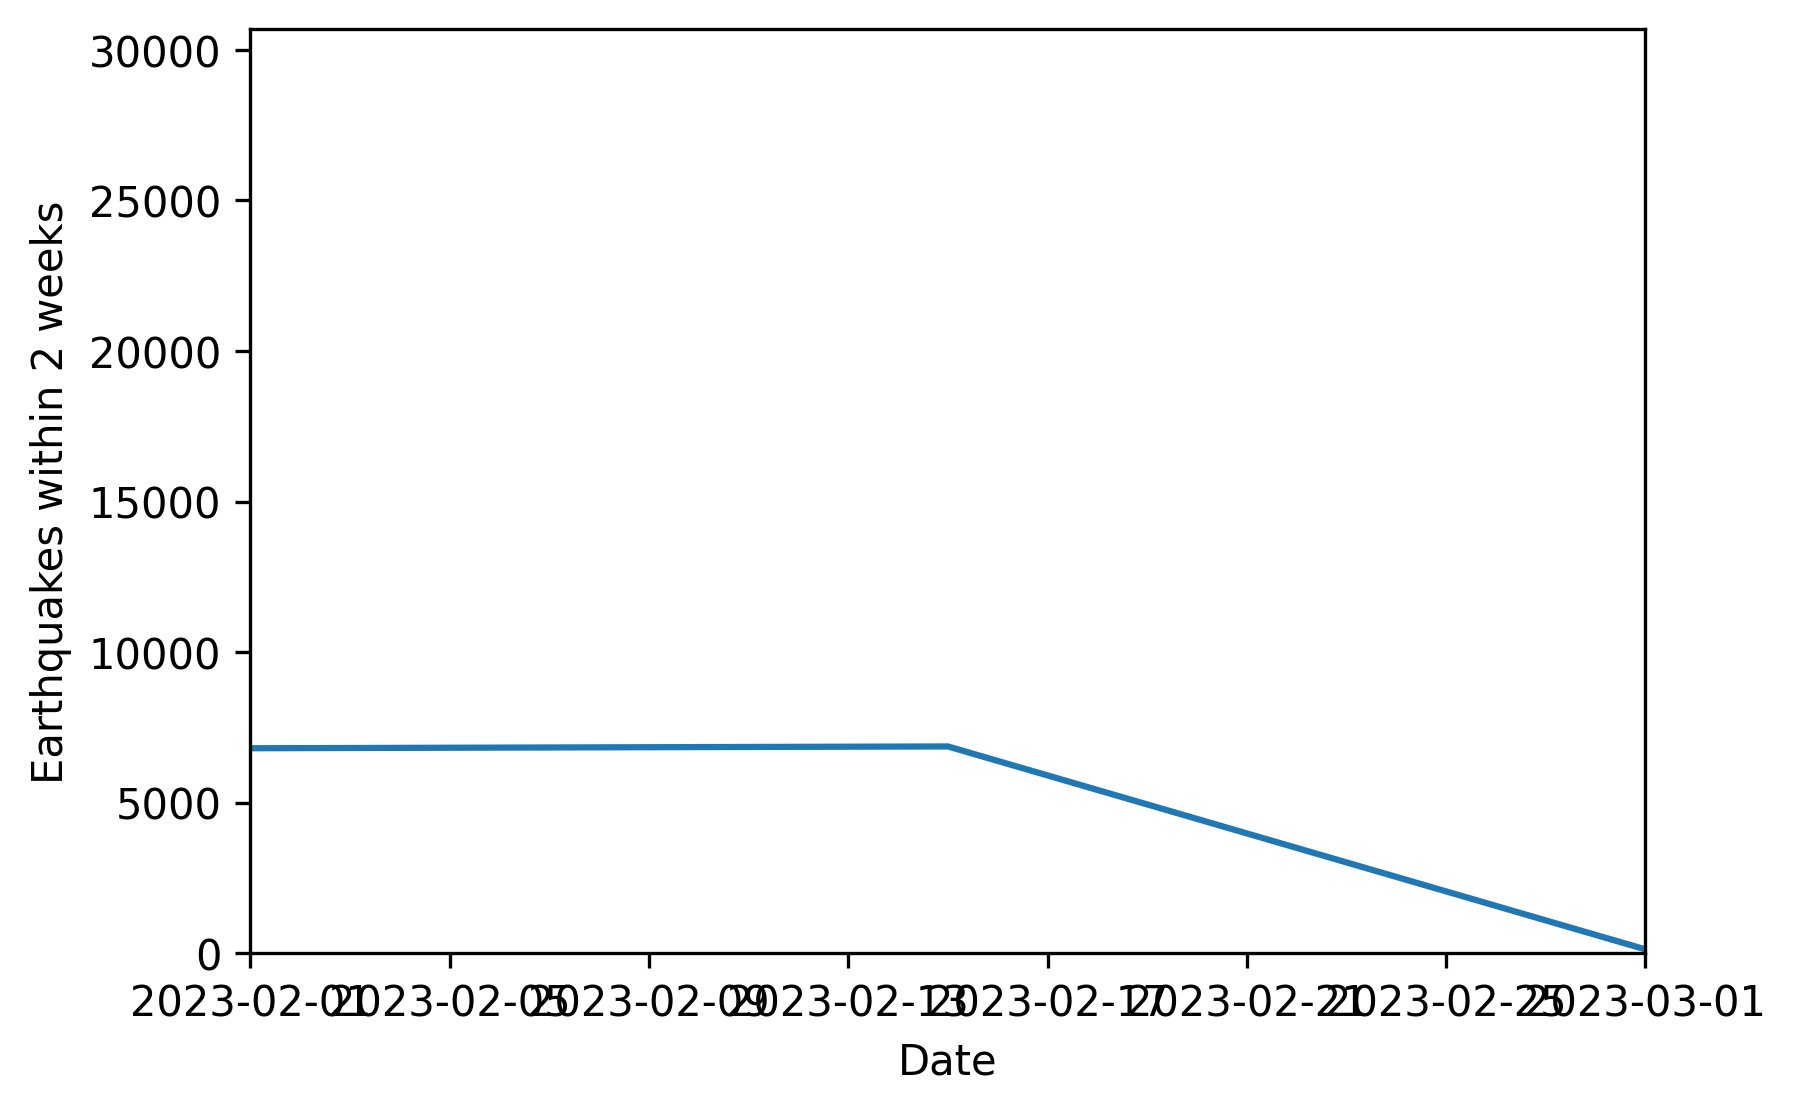

In [28]:
plot_EQ_per_file(datestrings, counts, (2023,2,1), (2023,3,1))

In [25]:
npzfile = np.load(masterdir + 'Japan_ISC.npz', allow_pickle=True)
catalog_mag  = npzfile['mag']
catalog_dat = npzfile['dat']


neq_geq7 = np.logical_and(catalog_dat > np.datetime64('2000-01-01'), catalog_mag >= 7).sum()

print('There are {} earthquakes with Magnitudes of 7 or above since 2000.'.format(neq_geq7))



There are 29 earthquakes with Magnitudes of 7 or above since 2000.
